<a href="https://colab.research.google.com/github/zhengchunqiu/Text-Classification/blob/master/Predicting_wine_quality_with_glove_vector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data from Kaggle
You can download data from kaggle https://www.kaggle.com/zynicide/wine-reviews/home

In [1]:
!mkdir -p ~/.kaggle
!echo '{"username":"***","key":"***"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d zynicide/wine-reviews
!unzip wine-reviews.zip

401 - Unauthorized
Archive:  wine-reviews.zip
replace winemag-data-130k-v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
!ls -l

total 7913708
-rw-rw-r-- 1 root root 5646236541 Oct 24  2015 glove.840B.300d.txt
-rw-r--r-- 1 root root 2176768927 Oct 24  2015 glove.840B.300d.zip
-rw-r--r-- 1 root root   45297552 May  8 08:36 model.h5
drwxr-xr-x 1 root root       4096 May  3 16:44 sample_data
-rw-r--r-- 1 root root   52908706 Nov 27  2017 winemag-data-130k-v2.csv
-rw-r--r-- 1 root root   79279294 Nov 27  2017 winemag-data-130k-v2.json
-rw-r--r-- 1 root root   49784334 Nov 27  2017 winemag-data_first150k.csv
-rw-r--r-- 1 root root   53336173 May  8 02:44 wine-reviews.zip


# Loading the data

In [0]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import os

In [4]:
train=pd.read_csv('winemag-data_first150k.csv',index_col=False)

print(train.shape)
train.head()

(150930, 11)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [5]:
train.describe()

,Unnamed: 0,points,price
count,150930.000000,150930.000000,137235.000000
mean,75464.500000,87.888418,33.131482
std,43569.882402,3.222392,36.322536
min,0.000000,80.000000,4.000000
25%,37732.250000,86.000000,16.000000
50%,75464.500000,88.000000,24.000000
75%,113196.750000,90.000000,40.000000
max,150929.000000,100.000000,2300.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


# Exploratory Data Analysis

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [0]:
stopwords=set(stopwords.words('english'))
detokenizer=TreebankWordDetokenizer()

In [0]:
def clean_description(desc):
  desc=word_tokenize(desc.lower())   # Lowercase text and tokenize it
  desc=[token for token in desc if token not in stopwords and token.isalpha()] # remove stopwords
  return detokenizer.detokenize(desc)  # combine words to sentence

In [11]:
clean_description('This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate')

'tremendous varietal wine hails oakville aged three years oak juicy fruit compelling hint caramel greet palate'

In [12]:
%%time
train['cleaned_description']=train['description'].apply(clean_description)

CPU times: user 1min 18s, sys: 134 ms, total: 1min 18s
Wall time: 1min 18s


In [13]:
train.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,cleaned_description
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,tremendous varietal wine hails oakville aged t...
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aromas fig blackberry cassis softened swe...
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,mac watson honors memory wine made mother trem...
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,spent months new french oak incorporates fruit...
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,top wine la bégude named highest point vineyar...


## （1）High frequency words in the text

In [14]:
word_occurrence=train['cleaned_description'].str.split(expand=True).stack().value_counts()
word_occurrence

wine              90497
flavors           77829
fruit             56506
finish            37724
aromas            35824
acidity           32603
tannins           32185
cherry            30659
palate            29011
ripe              26720
black             24590
drink             23630
dry               22978
spice             22644
sweet             21286
rich              21172
oak               19676
notes             19606
red               19190
soft              17745
fresh             17666
good              17291
berry             17098
nose              15888
shows             15766
blackberry        14948
crisp             13960
blend             13676
vanilla           13312
plum              13277
                  ...  
formless              1
boyd                  1
tainted               1
temptingly            1
overdose              1
lechet                1
blosser               1
engelbrecht           1
heaty                 1
spa                   1
aftican         

In [15]:
# Total number of words
total_words=sum(word_occurrence)
print(total_words)

3552938


In [16]:
# The 30 most common words
top_words=word_occurrence[:30]/total_words
top_words

wine          0.025471
flavors       0.021906
fruit         0.015904
finish        0.010618
aromas        0.010083
acidity       0.009176
tannins       0.009059
cherry        0.008629
palate        0.008165
ripe          0.007521
black         0.006921
drink         0.006651
dry           0.006467
spice         0.006373
sweet         0.005991
rich          0.005959
oak           0.005538
notes         0.005518
red           0.005401
soft          0.004994
fresh         0.004972
good          0.004867
berry         0.004812
nose          0.004472
shows         0.004437
blackberry    0.004207
crisp         0.003929
blend         0.003849
vanilla       0.003747
plum          0.003737
dtype: float64

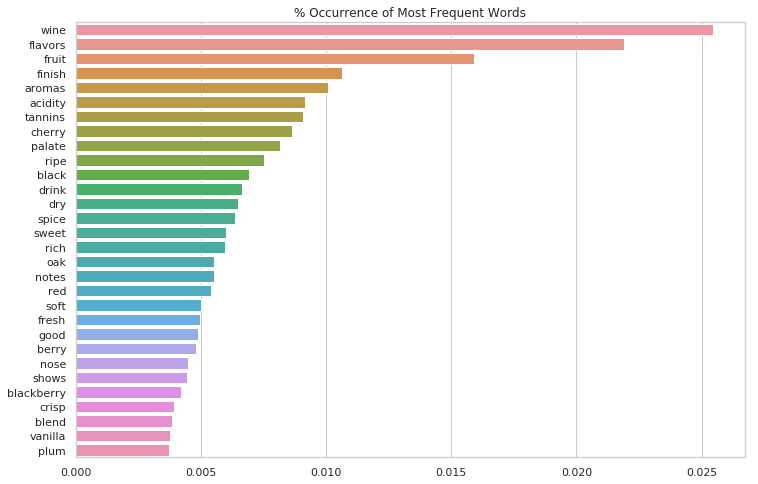

In [17]:
plt.style.use({'figure.figsize':(12, 8)})
sns.set(style='whitegrid')

ax=sns.barplot(x=top_words.values,y=top_words.index)
ax.set_title("% Occurrence of Most Frequent Words")
plt.show()

## （2）Prices of Reviewed Wine by Country

In [18]:
prices_by_country=train[['price','country']].dropna(how='any')
print(prices_by_country.shape)
prices_by_country.head()

(137230, 2)


,price,country
0,235.0,US
1,110.0,Spain
2,90.0,US
3,65.0,US
4,66.0,France


In [19]:
prices_by_country.describe()   

,price
count,137230.000000
mean,33.132019
std,36.323072
min,4.000000
25%,16.000000
50%,24.000000
75%,40.000000
max,2300.000000


In [20]:
val=prices_by_country['price'].quantile(0.98)   #Remove all data greater than the 98th percentile
print(val)

prices_by_country=prices_by_country[prices_by_country['price']<val]
print(prices_by_country.shape)
prices_by_country.describe()

120.0
(134455, 2)


,price
count,134455.000000
mean,29.692246
std,19.568355
min,4.000000
25%,15.000000
50%,24.000000
75%,38.000000
max,119.000000


In [21]:
prices_by_country.head()

,price,country
1,110.0,Spain
2,90.0,US
3,65.0,US
4,66.0,France
5,73.0,Spain


In [22]:
prices_by_country=prices_by_country.groupby('country').filter(lambda x:(x['price'].count()>=100))
prices_by_country.head()

,price,country
1,110.0,Spain
2,90.0,US
3,65.0,US
4,66.0,France
5,73.0,Spain


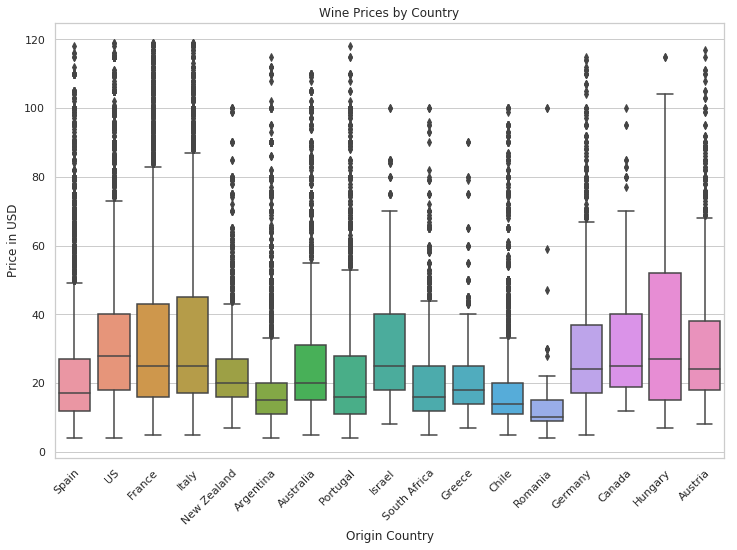

In [23]:
# Boxplot

ax=sns.boxplot(x='country',y='price',data=prices_by_country)
# Setting title 
ax.set_title("Wine Prices by Country")

# Assuming prices are in USD since its an American website
ax.set(xlabel = "Origin Country", ylabel = "Price in USD")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

## （3）Prices of Reviewed Wine by Variety

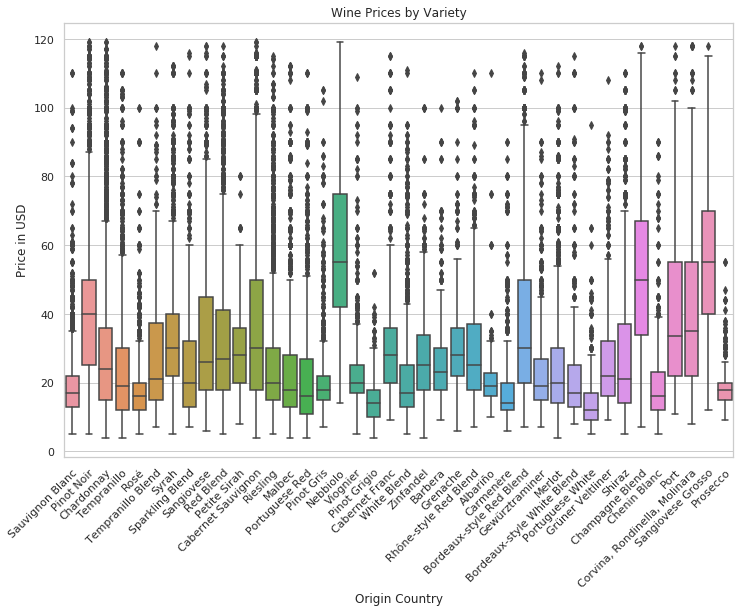

In [24]:
prices_by_variety = train[["price", "variety"]].dropna(how = "any")

# Remove all data greater than the 98th percentile
val = prices_by_variety["price"].quantile(0.98)
prices_by_variety = prices_by_variety[prices_by_variety["price"] < val]

# Only consider varieties where at least 500 wines have been reviewed
prices_by_variety = prices_by_variety.groupby("variety").filter(lambda x: (x["price"].count() >= 500))

# Creating a boxplot
ax = sns.boxplot(x="variety", y = "price", data=prices_by_variety)

# Setting title 
ax.set_title("Wine Prices by Variety")

# Assuming prices are in USD since its an American website
ax.set(xlabel = "Origin Country", ylabel = "Price in USD")

# Making sure ticks aren't overlapping
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor')

plt.show()

## （4）Ratings versus Price
There appears to be a correlation between rating and price

In [25]:
ratings_by_price=train[['price','points']]
ratings_by_price.head()

,price,points
0,235.0,96
1,110.0,96
2,90.0,96
3,65.0,96
4,66.0,95


In [0]:
val = ratings_by_price["price"].quantile(0.98)
ratings_by_price = ratings_by_price[ratings_by_price["price"] < val]

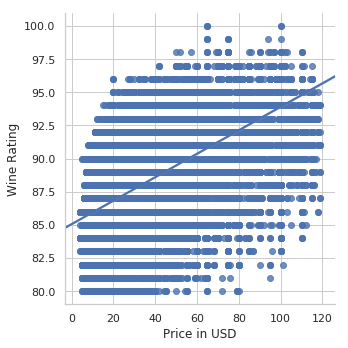

In [27]:
ax=sns.lmplot(x='price',y='points',data=ratings_by_price)
# Assuming prices are in USD since its an American website
ax.set(xlabel = "Price in USD", ylabel = "Wine Rating")

plt.show()

# Predicting Wine Scores from Text Descriptions
Classic: 98-100

Superb: 94-97

Excellent: 90-93

Very Good: 87-89

Good: 83-86

Acceptable: 80-82

In [28]:
from keras.models import Model,load_model
from keras.layers import Dense,Embedding,Input,Activation,CuDNNGRU,Bidirectional,Dropout,GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping,ModelCheckpoint,Callback

Using TensorFlow backend.


## Step 1.Preparing Data for Classification

In [29]:
# Converting Points to Classes 

def points_to_class(points):
  if points in range(80,83):
    return 0
  elif points in range(83,87):
    return 1
  elif points in range(87,90):
    return 2
  elif points in range(90,94):
    return 3
  elif points in range(94,98):
    return 4
  else:
    return 5
  
train['rating']=train['points'].apply(points_to_class)
train.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,cleaned_description,rating
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,tremendous varietal wine hails oakville aged t...,4
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aromas fig blackberry cassis softened swe...,4
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,mac watson honors memory wine made mother trem...,4
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,spent months new french oak incorporates fruit...,4
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,top wine la bégude named highest point vineyar...,4


In [30]:
train['rating'].value_counts()

2    51539
1    44740
3    41767
0     6441
4     6238
5      205
Name: rating, dtype: int64

In [31]:
# Unfortunately, our data is not very balanced.Combining Class 4 and 5 together as the new Class 4. Any reviews in the range or 94–100 points will fall under this class.

def points_to_class(points):
  if points in range(80,83):
    return 0
  elif points in range(83,87):
    return 1
  elif points in range(87,90):
    return 2
  elif points in range(90,94):
    return 3
  else:
    return 4
  
train['rating']=train['points'].apply(points_to_class)
train.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,cleaned_description,rating
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,tremendous varietal wine hails oakville aged t...,4
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,ripe aromas fig blackberry cassis softened swe...,4
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,mac watson honors memory wine made mother trem...,4
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,spent months new french oak incorporates fruit...,4
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,top wine la bégude named highest point vineyar...,4


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 13 columns):
Unnamed: 0             150930 non-null int64
country                150925 non-null object
description            150930 non-null object
designation            105195 non-null object
points                 150930 non-null int64
price                  137235 non-null float64
province               150925 non-null object
region_1               125870 non-null object
region_2               60953 non-null object
variety                150930 non-null object
winery                 150930 non-null object
cleaned_description    150930 non-null object
rating                 150930 non-null int64
dtypes: float64(1), int64(3), object(9)
memory usage: 15.0+ MB


In [33]:
train['rating'].value_counts()

2    51539
1    44740
3    41767
4     6443
0     6441
Name: rating, dtype: int64

In [0]:
# Fixed parameters

num_classes = 5
embedding_dim = 300 
epochs = 50
batch_size = 128
max_len = 100

# 类别权重
class_weights = {0: 7,
                1: 1,
                2: 1, 
                3: 1,
                4: 7}

In [0]:
# Onehot encoding target

def onehot(arr,num_classes):
  return np.eye(num_classes)[np.array(arr.astype(int)).reshape(-1)]

y=onehot(train['rating'],num_classes)

In [36]:
print(y.shape)
y

(150930, 5)


array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [0]:
# Train-Validation Split

from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val=train_test_split(train['description'],y,test_size=0.05)

## （2）Tokenizing Inputs and Preparing the Embedding Matrix
Several pre-trained GloVe word vectors can be downloaded https://nlp.stanford.edu/projects/glove/

In [0]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

In [0]:
!unzip glove.840B.300d.zip

In [0]:
embeddings_index={}

f=open('glove.840B.300d.txt',encoding='utf-8')

for line in f:
  values=line.split()
  word=''.join(values[:-embedding_dim])
  coefs=np.asarray(values[-embedding_dim:],dtype='float32')
  embeddings_index[word]=coefs
f.close()

In [0]:
# train tokenizer (only on training set)
tokenizer=Tokenizer(num_words=None)
tokenizer.fit_on_texts(X_train)

# fit tokenizer on training set
sequences_train=tokenizer.texts_to_sequences(X_train)
X_train=pad_sequences(sequences_train,maxlen=max_len)

# fit tokenizer on testing set
sequences_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(sequences_val, maxlen = max_len)

In [60]:
word_index=tokenizer.word_index
print(len(word_index))

embedding_matrix=np.zeros((len(word_index)+1,embedding_dim))
print(embedding_matrix.shape)

for word,i in word_index.items():
  embedding_vector=embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector

36615
(36616, 300)


## （3）Training the classifier


1.   Since the text descriptions are generally short, I will be using GRU units as opposed to LSTM units. With shorter descriptions, we have less need for a memory unit and can benefit from GRU’s more efficient learning algorithm.
2. I will also be utilizing early stopping, which (in this case) uses validation accuracy to determine whether we should continue training the network. When validation accuracy continuously drops over several epochs, early stopping will kick in and end the training process. It will also save the optimal weights as a “checkpoint” (in this case as model.h5) and rewrite the weights if accuracy improves. With early stopping, we can let the network train for many epochs without worrying too much about overfitting.

In [71]:
embedding_layer=Embedding(len(word_index)+1,embedding_dim,weights=[embedding_matrix],input_length=max_len,trainable=False)

input=Input(shape=(max_len,),dtype='int32')
embedded_sequences=embedding_layer(input)
x=Bidirectional(CuDNNGRU(50,return_sequences=True))(embedded_sequences)
x=GlobalMaxPooling1D()(x)
x=Dense(50,activation='relu')(x)
x=Dropout(0.1)(x)
output=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=input,outputs=output)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 300)          10984800  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 100)          105600    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 255       
Total para

In [0]:
checkpoint=ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True,mode='min')
early=EarlyStopping(monitor='val_loss',mode='min',patience=3)
callback=[checkpoint,early]

In [73]:
model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_val,y_val),callbacks=callback,class_weight=class_weights)

Train on 143383 samples, validate on 7547 samples
Epoch 1/50
143383/143383 [==============================] - 17s 117us/step - loss: 1.3872 - acc: 0.4908 - val_loss: 0.9689 - val_acc: 0.5517

Epoch 00001: val_loss improved from inf to 0.96887, saving model to model.h5
Epoch 2/50
143383/143383 [==============================] - 16s 111us/step - loss: 1.1230 - acc: 0.5761 - val_loss: 0.9143 - val_acc: 0.5792

Epoch 00002: val_loss improved from 0.96887 to 0.91431, saving model to model.h5
Epoch 3/50
143383/143383 [==============================] - 16s 110us/step - loss: 1.0295 - acc: 0.6077 - val_loss: 0.8058 - val_acc: 0.6304

Epoch 00003: val_loss improved from 0.91431 to 0.80579, saving model to model.h5
Epoch 4/50
143383/143383 [==============================] - 16s 109us/step - loss: 0.9653 - acc: 0.6278 - val_loss: 0.9503 - val_acc: 0.5588

Epoch 00004: val_loss did not improve from 0.80579
Epoch 5/50
143383/143383 [==============================] - 18s 123us/step - loss: 0.9092 - 

## （4）Evaluate on Testing Set

In [74]:
from sklearn.metrics import accuracy_score

test = pd.read_csv("winemag-data-130k-v2.csv", index_col = False)
test["rating"] = test["points"].apply(points_to_class)

sequences_test = tokenizer.texts_to_sequences(test["description"])
X_test = pad_sequences(sequences_test, maxlen=max_len)

# Predictions
pred_test = model.predict(X_test)
pred_test = [np.argmax(x) for x in pred_test]

# Actual
true_test = onehot(test["rating"], num_classes)
true_test = [np.argmax(x) for x in true_test]

# Find accuracies
accuracy = accuracy_score(true_test, pred_test)
print("The total accuracy is ", accuracy)

The total accuracy is  0.6473367135745667


## Accuracy over Test Set: 64.7%

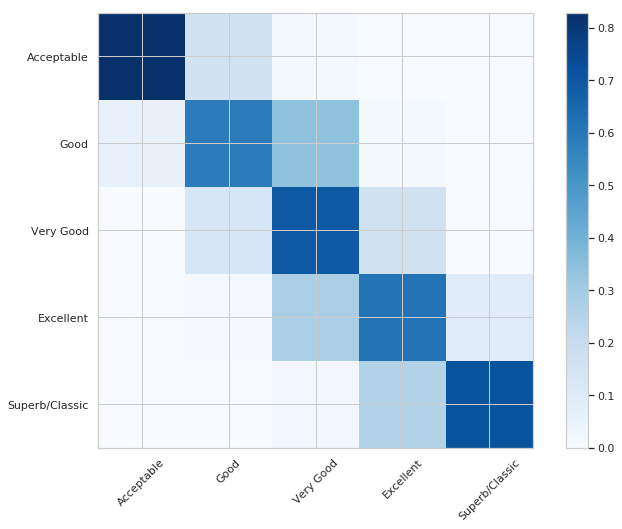

In [75]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_test, pred_test)

# measuring by percentage correct
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

class_name = ["Acceptable", "Good", "Very Good", "Excellent", "Superb/Classic"]
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)

plt.show()